In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

# Benchmarking
import time

# Cutting 

from cut_audio import *

%matplotlib inline

### Get original features

In [2]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_all_raw_10_1028_20.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         0  ../Project/data/train/audio/bed/988e2f9a_nohas...  988e2f9a  bed   
1         2  ../Project/data/train/audio/bed/6d818f6c_nohas...  6d818f6c  bed   
2         0  ../Project/data/train/audio/bed/93ec8b84_nohas...  93ec8b84  bed   
3         1  ../Project/data/train/audio/bed/a9abc695_nohas...  a9abc695  bed   
4         0  ../Project/data/train/audio/bed/a8cb6dda_nohas...  a8cb6dda  bed   

      mfcc                                                ...               \
  raw_mfcc                                                ...                
         0        1        2        3        4        5   ...          190   
0 -532.804 -373.747 -281.723 -259.193 -260.494 -258.983   ...       1.9078   
1 -407.218 -255.981  -163.47  -131.31 -112.495  -118.76   ...    -0.523793   
2 -466.171 -337.843 -244.057 -223.569 -248.308 -250.754   ...     -19.4222   
3 -556.172 -371.435 -267.924 -229.983 -221.044 -213.585   ...     -13.8834   
4 -483.963 -384.623 -221.676 -136.899 -108.406 -110.998   ...      9.02163   

                                                                           \
                                                                            
       191      192      193      194      195      196      197      198   
0 -6.68038 -12.3779 -7.88019 -4.89838  5.09246  5.23662  5.81571    2.533   
1 -2.98547  -3.1049 -10.3242 -19.2463 -25.6867 -23.1932 -13.7993 -17.9949   
2 -8.93999 -2.63587 -2.76918 -9.29244 -14.9003 -17.6517 -15.8084 -25.7532   
3 -18.6183 -15.9497 -13.2618 -9.06467 -12.7498 -12.3417 -14.7705 -19.5946   
4  2.85084 -1.81553 -2.05279  0.79797 -2.28227 -10.0107 -13.8224 -10.9754   

            
            
       199  
0  3.65357  
1   -12.81  
2 -30.9885  
3 -22.2862  
4 -9.73626  

[5 rows x 204 columns]

### Create balanced training and testing set

In [3]:
features_og.shape

(64720, 204)

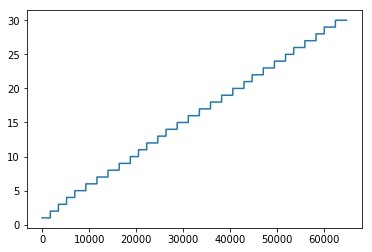

In [27]:
#features_og['mfcc']

# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
label_vec = np.ones(len(features_og))
for i in range(0,len(class_names)):
    label_vec +=(features_og['info','word'] == class_names[i]) * i
    
#equalize label count
#label_vec = label_vec[1800:]    

label_vec.plot()

In [28]:
# sample classes such as test and train have equal proportion of classes
train_size = 160
test_size = 100

train_x = np.array([])
train_y = np.array([])

test_x = np.array([])
test_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(label_vec == (i+1))[0]
    random_index = np.random.choice(range(len(class_index)), size=train_size+test_size, replace=False)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = label_vec[train_x_class]
    train_x = np.append(train_x, train_x_class).astype(int)
    train_y = np.append(train_y, train_y_class).astype(int)

    test_x_class = class_index[random_index[train_size:train_size+test_size]]
    test_y_class = label_vec[test_x_class]
    test_x = np.append(test_x, test_x_class).astype(int)
    test_y = np.append(test_y, test_y_class).astype(int)
    

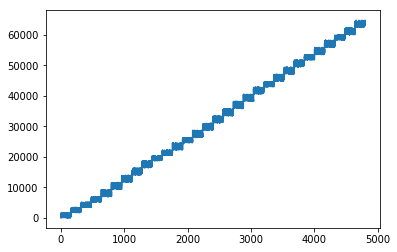

In [29]:
plt.plot(train_x)

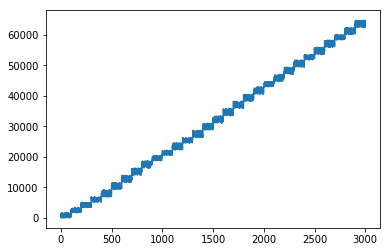

In [30]:
plt.plot(test_x)

### Semisupervised learning functions

In [31]:
# Functions
def prepare_observations(Y, perc):
    """Prepare observations, where p is the percentage of values to keep."""
    M = np.array(np.random.random_sample(np.shape(Y))>(1-perc),dtype = 'int64')
    Y_compr = Y*M
    return Y_compr, M

def solve(Y_compr, M, L, alpha, beta):
    X = np.ones(Y_compr.shape)
    for i in range(Y_compr.shape[0]):
        Mask = np.diag(M[i,:])
        #Mask = sparse.csr_matrix(Mask)
        y_i_compr = Y_compr[i,:]
        X[i,:] = np.linalg.solve((Mask+alpha*L+beta),y_i_compr)
        #X[i,:] = scipy.sparse.linalg.spsolve((Mask+alpha*L+beta),y_i_compr)
  
    return X

def adapt_labels(x_hat):
    # Real accuracy considering only the main words :
    class_names_list = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    mask_names_main = [True if name in class_names_list else False for name in class_names]
    index_names_main = [i for i in range(len(mask_names_main)) if mask_names_main[i] == True]
    inverted_index_names = dict(zip(index_names_main,range(len(index_names_main))))

    # Creating the label names :
    class_names_main = class_names[mask_names_main].tolist()
    class_names_main.extend(["unknown"])

    # Adapting the labels in the test and prediction sets :
    return np.array([inverted_index_names[int(x_hat[i])] if x_hat[i] in index_names_main else len(class_names_main)-1 for i in range(len(x_hat)) ])


### Main loop :

In [32]:
batch_size = 200
NEIGHBORS = 30
n_batch = int(len(test_x) / batch_size)

alpha = 1e-3
beta = 1e-7

In [33]:
accuracy_tot = []
accuracy = []
remaining_test = np.array(test_x)

# encode training samples classes into 1-hot array
n_class = np.max(train_y)
Y = np.eye(len(class_names))[train_y - 1].T

for batch in tqdm(range(n_batch)):
    potential_elements  = np.array(list(enumerate(remaining_test)))
    indices = np.random.choice(potential_elements[:,0].reshape(-1,), batch_size, replace=False)
    batch_index = potential_elements[:,0].reshape(-1,)[indices]
    remaining_test = np.delete(remaining_test, indices)
        
    features = pd.DataFrame(features_og['mfcc'], np.append(train_x, batch_index))
    features -= features.mean(axis=0)
    features /= features.std(axis=0)

    # keep mapping from batch id to main id
    id_mapping = dict(zip(features.index, range(len(features))))
    
    distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

    n=distances.shape[0]
    kernel_width = distances.mean()
    weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
    np.fill_diagonal(weights,0)
    
    for i in range(weights.shape[0]):
        idx = weights[i,:].argsort()[:-NEIGHBORS]
        weights[i,idx] = 0
        weights[idx,i] = 0
        
    degrees = np.sum(weights,axis=0)
    laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
    laplacian = sparse.csr_matrix(laplacian)

    # add test samples to 1-hot array
    M = np.zeros((len(class_names), len(train_y) + batch_size)) # mask matrix
    M[:len(train_y),:len(train_y)] = 1
    Y_compr = np.concatenate((Y, np.zeros((len(class_names), batch_size))), axis=1)
    y = np.concatenate((train_y,np.zeros((batch_size,))))

    # Solve
    X = solve(Y_compr, M, laplacian, alpha = alpha, beta = beta)

    # Make label vector
    x_hat = np.argmax(X,axis = 0)+np.ones(X[0,:].shape)

    # Unify labels 13-30
    x_hat_adapted = adapt_labels(x_hat)
    true_y = np.concatenate((train_y,label_vec[batch_index]))
    y_adapted = adapt_labels(true_y)
    
    # Only consider unknowns
    accuracy_tot.append(np.sum(x_hat[(len(x_hat)-batch_size):]==true_y[(len(x_hat)-batch_size):])/batch_size) # for all 30 words
    accuracy.append(np.sum(x_hat_adapted[(len(x_hat)-batch_size):]==y_adapted[(len(x_hat)-batch_size):])/batch_size) # only core words
    

100%|█████████████████████████████████████████| 15/15 [26:27<00:00, 105.82s/it]


In [35]:
#print(accuracy_tot)
print(accuracy)
print('The achieved overall accuracy was {}%'.format(round(np.sum(accuracy)/len(accuracy)*100)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
The achieved overall accuracy was 100.0%
